# Exploration des requêtes de StackOverFlow

In [114]:
# librairie de manipulation de fichiers/dossiers
from pathlib import Path

# libraires de manipulation des données
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import json

# librairies de visulation des données
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# module de chargement des données
import FETCH_LOAD_DATAS

In [112]:
pd.set_option('display.max_row', 100)

plt.rcParams['figure.figsize'] = [10, 8]

In [ ]:
IMAGES_PATH = Path() / "img" / "exploration"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
ID_FIG = 0

def save_fig(fig_title, resolution=300):
    fig_id = str(globals()['ID_FIG'])
    path = IMAGES_PATH / f"exploration - {fig_id} - {fig_title}.png"
    globals()['ID_FIG']+=1
    plt.savefig(path, format='png', dpi=resolution)

In [115]:
DICT_PATH = Path() / "dictionnaries"
DICT_PATH.mkdir(parents=True, exist_ok=True)

def save_dict(dictionnary, dict_file_name):
    path_file = DICT_PATH / f"{dict_file_name}.json"
    with open(path_file, "w") as outfile:
        json.dump(dictionnary, outfile)

In [ ]:
# %%time
# raw_queries = FETCH_LOAD_DATAS.load_stackoverflow_questions()

In [ ]:
# %%time
# raw_queries.to_pickle(path='datasets/raw_queries.pkl')

In [ ]:
%%time
raw_queries = pd.read_pickle('datasets/raw_queries.pkl')

## Récupération des données

Afin d'automatiser au plus la tâche de récupération, nous avons utilisé la plateforme **Google BigQuery** qui propose l'accès aux données du site **StackOverFlow** sans les contraintes de limites de 50000 résultats via la page de requête SQL proposée sur **StackExchange**.

Cela nous permet de créer une requête unique pour récupérer autant de posts que nécessaires, et de récupérer ces données brutes d'une manière plus automatisée et plus prompte à être intégrer dans le pipeline global d'un projet de Machine Learning voué à être maintenu et à évoluer dans le temps.

Nous récupérons ainsi 1 million de posts publiés à partir de **Janvier 2020** :

<pre>
SELECT
    question_id, creation_date, title, body, tags, score, view_count, answer_count
FROM
  (SELECT
    EXTRACT ( DATETIME from q.creation_date ) as creation_date,
    q.id as question_id,
    q.title as title,
    q.body as body,
    q.tags as tags,
    q.score as score,
    q.view_count as view_count,
    q.answer_count as answer_count
   FROM 
    `bigquery-public-data.stackoverflow.posts_questions` q
   WHERE
    DATETIME(creation_date) > DATETIME('2022-01-01') 
    AND (score > 5)
    AND (answer_count > 2)
    AND (view_count > 10)
    )

ORDER BY 
  creation_date

LIMIT 1000000
</pre>

# Composititon du jeu de données brut

In [6]:
df = raw_queries.copy()
df.sort_values('question_id', inplace=True)
df.reset_index(drop=True, inplace=True)
df

,question_id,creation_date,title,body,tags,score,view_count,answer_count
0,59549239,2020-01-01 00:07:37.293,Modifying Bonita Process Instance after Started,<p>Is it possible to change the processinstanc...,bonita,1,63,1
1,59549244,2020-01-01 00:09:53.770,What does Elevation in DrawShadow do exactly?,"<p>I know that <a href=""https://github.com/flu...",c++|flutter|dart|skia,3,380,1
2,59549281,2020-01-01 00:23:15.297,How to use a trait object that contains a meth...,<p>What's the correct way to use a trait objec...,rust,3,952,1
3,59549286,2020-01-01 00:24:49.650,A way for users to store selections as inputs ...,<p>I'm trying to create a way in which a user ...,r|shiny|shiny-server|shiny-reactivity|shinyapps,2,78,1
4,59549303,2020-01-01 00:30:49.253,How to open downloaded photo using gallery app...,"<p>I am facing a problem, cannot figure out ho...",react-native|linker|expo|gallery,5,3235,1
...,...,...,...,...,...,...,...,...
999995,73842028,2022-09-25 04:18:10.303,Can you do a $pull in a MongoDB Bulk Write whi...,<p>Version: MongoDB v 4.2.18.</p>\n<p>I have t...,mongodb,1,14,1
999996,73842042,2022-09-25 04:23:21.587,non static method can't be called statically,<p>I am so lost with how to get this working. ...,php|laravel,1,22,1
999997,73842118,2022-09-25 04:50:21.720,Sorting os.listdir()'s arbitrary order for des...,"<p><a href=""https://i.stack.imgur.com/kM7UP.pn...",python|list|sorting,1,18,1
999998,73842153,2022-09-25 05:03:58.270,Big O complexity of nested loop,<p>What could be the big O of this code?</p>\n...,big-o,1,13,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   question_id    1000000 non-null  int64 
 1   creation_date  1000000 non-null  object
 2   title          1000000 non-null  object
 3   body           1000000 non-null  object
 4   tags           1000000 non-null  object
 5   score          1000000 non-null  int64 
 6   view_count     1000000 non-null  int64 
 7   answer_count   1000000 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 61.0+ MB


# Analyse univariée

In [8]:
df.describe(include='all')

,question_id,creation_date,title,body,tags,score,view_count,answer_count
count,1.000000e+06,1000000,1000000,1000000,1000000,1000000.000000,1.000000e+06,1000000.000000
unique,NaN,999966,999986,999980,520831,NaN,NaN,NaN
top,NaN,2022-08-15 12:23:15.537,regular expression,<p>I am using Firebase pagging and therefore i...,python|pandas,NaN,NaN,NaN
freq,NaN,2,3,2,7421,NaN,NaN,NaN
mean,6.648279e+07,NaN,NaN,NaN,NaN,1.915529,9.456922e+02,1.476712
std,4.141736e+06,NaN,NaN,NaN,NaN,3.820307,3.989045e+03,0.894424
min,5.954924e+07,NaN,NaN,NaN,NaN,1.000000,5.000000e+00,1.000000
25%,6.274741e+07,NaN,NaN,NaN,NaN,1.000000,7.800000e+01,1.000000
50%,6.618217e+07,NaN,NaN,NaN,NaN,1.000000,2.250000e+02,1.000000
75%,7.017905e+07,NaN,NaN,NaN,NaN,2.000000,7.160000e+02,2.000000


### Duplictats

In [9]:
df[df.duplicated(keep=False)]

,question_id,creation_date,title,body,tags,score,view_count,answer_count


#### creation_date

In [10]:
df[df.duplicated(subset=['creation_date'], keep=False)].sort_values('creation_date')

,question_id,creation_date,title,body,tags,score,view_count,answer_count
5384,59651180,2020-01-08 17:44:02.893,Testing Neo4jClient queries on .NET Core (tran...,<p>I've started to write some tests for my Neo...,c#|testing|.net-core|neo4j|neo4jclient,1,109,1
5385,59651181,2020-01-08 17:44:02.893,"How to type ""recursive object of primitives""?",<p>I'm trying to come up with an interface tha...,typescript,1,77,1
11202,59761729,2020-01-16 01:09:51.617,Is it possible to attach Qt creator to a runni...,"<p>I have a running gdb session, that is attac...",debugging|gdb|qt-creator,1,104,1
11203,59761730,2020-01-16 01:09:51.617,How to update value of input type=range,<p>Why in my <code>playbackChange</code> funct...,javascript|html,3,44,1
102269,60930083,2020-03-30 12:01:48.647,How does Garbage Collection identify orphaned ...,<p>Given a memory state like this:</p>\n\n<pre...,java|android|garbage-collection,2,235,1
102270,60930084,2020-03-30 12:01:48.647,"Cats a List of State Monads ""fail fast"" on <.....",<p>let's say we have a list of states and we w...,scala|state|sequence|monads,2,90,1
122870,61157723,2020-04-11 13:42:54.383,I want to add a try/catch block for bad user i...,"<p>Below is my code, I want to add a try/catch...",java,1,238,1
122871,61157724,2020-04-11 13:42:54.383,Write a regex that recognizes dogs and cats th...,"<p>The program asks me to ""Write a regex that ...",regex,2,101,1
212434,62314939,2020-06-10 23:52:42.933,TFX - REST API Without Serializing the Data In...,"<p>I'm new to TFX, and I've been following thr...",python|python-3.x|tensorflow2.0|tfx,3,437,1
212435,62314940,2020-06-10 23:52:42.933,"Why do I get an ""arity mismatch"" error? Exerci...","<p>I'm working on <a href=""https://mitpress.mi...",racket|sicp,3,367,1


> Les duplicats sur la colonne 'creation_date' ont l'air légitimes, car ils correspondent à des posts différents. Seulement, l'enregistrement des posts doit être fait selon une certaine horloge rendant possible la prise en compte "simultanée" de posts ayant été soumis à des moments très proches.

In [50]:
df['creation_date'] = pd.to_datetime(df['creation_date']).dt.date
df.sort_values("creation_date", inplace=True)

#### title

In [12]:
df[df.duplicated(subset=['title'], keep=False)].sort_values('title')

,question_id,creation_date,title,body,tags,score,view_count,answer_count
142568,61562284,2020-05-02,Could not load file or assembly,<p>I have the following problem when I tried t...,c#|asp.net|iis|load|.net-assembly,2,4267,1
216077,62356480,2020-06-13,Could not load file or assembly,<p>I am using aws lamda function to connect my...,sql|amazon-web-services|cloud|amazon-rds,1,767,1
950476,73037072,2022-07-19,Download files using url in javascript,"<p>I have multiple url's, pointing to pdf's in...",javascript|http|next.js,1,87,1
953251,73078819,2022-07-22,Download files using url in javascript,"<p>I have multiple url's, pointing to differen...",javascript|http|https|next.js|download,1,412,2
537050,66820825,2021-03-26,Error CS0579 Duplicate 'global::System.Runtime...,"<p>I have 2 projects in a solution, and I am n...",c#,5,5172,4
183700,61997928,2020-05-25,Error CS0579 Duplicate 'global::System.Runtime...,<p>When I build my application I get the follo...,netcoreapp3.1,89,71831,20
808654,70940983,2022-02-01,Exception: The number of rows in the range mus...,<p>I'm trying to run this code that will get t...,javascript|google-apps-script|google-sheets,1,613,1
498343,66164624,2021-02-11,Exception: The number of rows in the range mus...,<p>I am having trouble writing my json data to...,json|google-apps-script|google-sheets,1,602,2
492720,66103047,2021-02-08,Google service account: Delegate Domain-Wide D...,<p>We need to access Google Calendar API with ...,google-calendar-api|google-workspace|service-a...,2,1042,1
492307,66098218,2021-02-08,Google service account: Delegate Domain-Wide D...,<p>We need to access Google Calendar API with ...,google-calendar-api|google-workspace|service-a...,2,159,1


> Les duplicats que nous observons parmi les titres semblent provenir des mêmes utilisateurs qui ont reformulé leur problème à des dates différentes, soit parce qu'ils n'ont pas obtenu de réponse satisfaisante, soit parce qu'ils ont avancé dans la résolution de leur problème et exposent leur avancée pour solliciter un nouvel avis éclairé. 

A chaque fois, le deuxième post change de tags et de corps, et voit ainsi évoluer le nombre de vues générées, le score du post ainsi que le nombre de réponse.

**Nous conservons les duplicats sur la colonne 'title' pour garder ces différences dans le jeu**.

#### body

In [13]:
df[df.duplicated(subset=['body'], keep=False)].sort_values('body')

,question_id,creation_date,title,body,tags,score,view_count,answer_count
965050,73262411,2022-08-06,How to perform addition for each mapping itera...,<p>EDIT: deleted due to qustion being outdated...,javascript|reactjs,1,33,2
961854,73211130,2022-08-02,Counter inside an onClick function,<p>EDIT: deleted due to qustion being outdated...,javascript|reactjs,1,45,1
286709,63373358,2020-08-12,saving an icon to shared preference in flutter,<p>I am still struggling to save an iconData t...,flutter|dart,1,304,1
303137,63562958,2020-08-24,Saving the users icon input to shared preferences,<p>I am still struggling to save an iconData t...,flutter|icons|sharedpreferences,1,113,2
649918,68769109,2021-08-13,How to query so that a field of each instance ...,<p>I am trying to query so that the value for ...,python|django|django-models|django-forms|djang...,1,61,2
652316,68798775,2021-08-16,How to query so that a field of a model will s...,<p>I am trying to query so that the value for ...,python|django|django-models|django-forms|djang...,1,35,1
666210,68962775,2021-08-28,How to get system Timestamp for Firebase? in k...,<p>I am using Firebase pagging and therefore i...,android|kotlin,1,65,1
275400,63170440,2020-07-30,How to get current System Timestamp for Fireba...,<p>I am using Firebase pagging and therefore i...,firebase|kotlin|google-cloud-firestore,4,601,2
6717,59676566,2020-01-10,Add Images in the react-native-modal-selector,<p>I created a modal using <code>react-native-...,react-native,1,246,2
8599,59711915,2020-01-13,Add images or Icons in the react-native-modal-...,<p>I created a modal using <code>react-native-...,react-native,1,334,2


> De même que pour la colonne **'title'**, nous conservons les duplicats de la colonne **'body'**

### Distribution des variables numériques

--------------------
SCORE


moyenne:
 1.92
médiane:
 1.0
mode:
 [1]
variance:
 12.33
écart-type:
 3.51
skwewness:
 25.5
kurtosis:
 1183.81
minimum:
 1
maximum:
 258


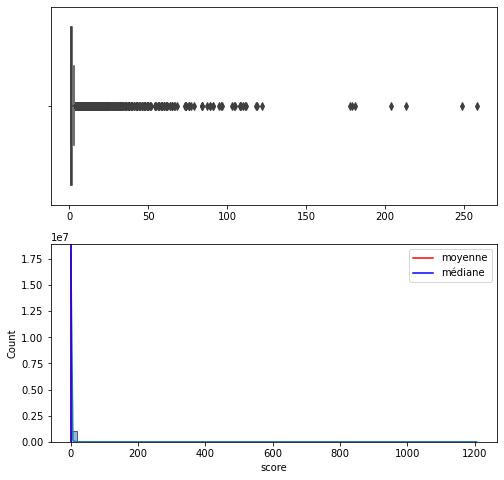

--------------------
VIEW_COUNT


moyenne:
 946.95
médiane:
 224.0
mode:
 [48]
variance:
 13295561.3
écart-type:
 3646.31
skwewness:
 23.8
kurtosis:
 977.07
minimum:
 8
maximum:
 273073


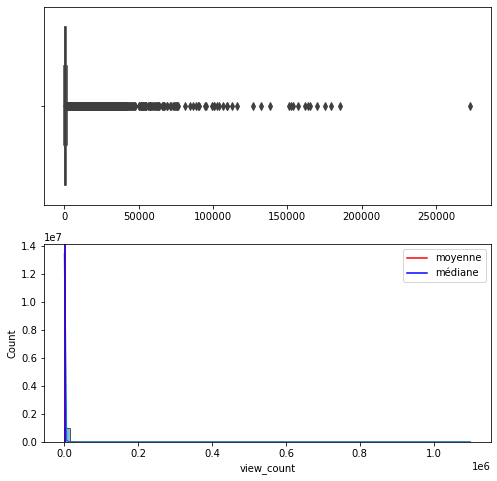

--------------------
ANSWER_COUNT


moyenne:
 1.48
médiane:
 1.0
mode:
 [1]
variance:
 0.83
écart-type:
 0.91
skwewness:
 5.19
kurtosis:
 81.16
minimum:
 1
maximum:
 35


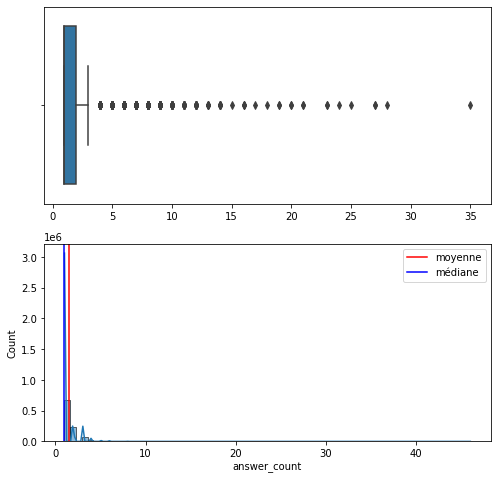

In [14]:
for col in df.select_dtypes(include=np.number):
    if col != 'question_id':
        subset = df[col].sample(100000)
        print("-"*20)
        print(col.upper())
        print('\n')
        print("moyenne:\n",np.round(subset.mean(),2))
        print("médiane:\n",np.round(subset.median(),2))
        print("mode:\n",np.round(subset.mode().values,2))
        print("variance:\n",np.round(subset.var(ddof=0),2))
        print("écart-type:\n",np.round(subset.std(ddof=0),2))
        print("skwewness:\n",np.round(subset.skew(),2))
        print("kurtosis:\n",np.round(subset.kurtosis(),2))
        print("minimum:\n",np.round(subset.min(),2))
        print("maximum:\n",np.round(subset.max(),2))
        fig = plt.figure(figsize=(8,8))
        plt.subplot(2,1,1)
        ax1 = sns.boxplot(x=subset)
        ax1.set(xlabel=None)
        plt.subplot(2,1,2)
        ax2 = sns.histplot(x=df[col], kde=True, bins=70)
        plt.axvline(x=df[col].mean(), color='r', label='moyenne')
        plt.axvline(x=df[col].median(), color='b', label='médiane')
        plt.legend()
        #save_fig(f"")
        plt.show()

> Les variables numériques suivent toutes une **loi exponentielle**.

# Title

In [15]:
df['title']

0           Modifying Bonita Process Instance after Started
1             What does Elevation in DrawShadow do exactly?
2         How to use a trait object that contains a meth...
3         A way for users to store selections as inputs ...
4         How to open downloaded photo using gallery app...
                                ...                        
999995    Can you do a $pull in a MongoDB Bulk Write whi...
999996         non static method can't be called statically
999997    Sorting os.listdir()'s arbitrary order for des...
999998                      Big O complexity of nested loop
999999    How to convert comma separated string to list ...
Name: title, Length: 1000000, dtype: object

In [16]:
for title in df['title'].sample(10):
    print(title+'\n')

Visual Studio lists parameters names in front of arguments to functions in C

How do I prevent <span> element from getting created if certain property in $root is null?

How can I use a child component in the parent component?

Combining two dataframes

How can I enforce all properties from an optional intersection

I can't fetch the data from reducer to component

How to add a marker in flutter to the Yandex MapKit?

Filter HTML Table using JavaScript - textContent Error

Make Zoho CRM extension using Angular

In Azure DevOps, How to schedule a Release Pipeline for quarterly execution?



### Contenu entre crochets

In [17]:
brackets_titles = df[df['title'].str.contains('[', regex=False)]
for _, row in brackets_titles.sample(10).iterrows():
    print(f"Titre : {row['title']}"+'\n')
    print(f"Tags : {row['tags']}"+'\n')
    print("-"*20+'\n'*2)

Titre : Why use (regressor.layers[0].input, regressor.layers[-1].output) instead of just regressor in DeepExplainer?

Tags : python|tensorflow|time|lstm|shap

--------------------


Titre : "ERROR: Could not install packages due to an EnvironmentError: [Errno 28] No space left on device" even though I've 100 GB+ of Space left in it

Tags : python|pip|installation

--------------------


Titre : Why does Python return [15] for [0xfor x in (1, 2, 3)]?

Tags : python|python-3.x|operator-precedence|short-circuiting

--------------------


Titre : FAIL - Encountered exception [org.apache.catalina.LifecycleException - Tomcat 9

Tags : tomcat|grails|server

--------------------


Titre : [google-assistant-sdk]- broadcasting problem

Tags : broadcast|google-assistant-sdk

--------------------


Titre : Powershell [Environment] inconsistencies

Tags : powershell|environment-variables

--------------------


Titre : ASP.NET Core 6 getting Microsoft.AspNetCore.Server.Kestrel.Https.Internal.HttpsC

> A priori, le contenu entre crochets semble plus souvent être peu pertinent vis-à-vis des tags (utilisation du crochet dans un contexte technique, ici code plutôt que dans un contexte sémantique de mise en valeur d'une information).

### Contenu des parenthèses

In [18]:
parenthesis_titles = df[df['title'].str.contains('()', regex=False)]
for index, row in parenthesis_titles.sample(10).iterrows():
    print(f"Titre : {row['title']}"+'\n')
    print(f"Tags : {row['tags']}"+'\n')
    print("-"*20+'\n'*2)

Titre : Stop setInterval() when Component Unmounts? (React)

Tags : javascript|reactjs|intervals

--------------------


Titre : Error: "You may not call store.getState() while the reducer is executing." when changing language with react-i18next

Tags : reactjs|redux|i18next|react-i18next

--------------------


Titre : Create pop() function stack implementation in C

Tags : c|char|stack|scanf|singly-linked-list

--------------------


Titre : Why an error "blocking, which is not supported in thread reactor-http-nio-4" despite using Mono.fromCallable()?

Tags : kotlin|azure-blob-storage|spring-webflux|project-reactor

--------------------


Titre : How to fix unstable y-positions for geom_jitter() for ggplot2 in R?

Tags : r|ggplot2|jitter

--------------------


Titre : Working of sort() in c++ while sorting strings

Tags : c++|arrays|sorting|c++14

--------------------


Titre : Is it possible to foreign key on bulk_create() Django?

Tags : mysql|django|django-models

---------------

> Même remarque pour le contenue entre parenthèses que pour le contenu entre crochets (ici le contenu entre parenthèses est rarement un contenu information supplémentaire ou une précision par rapport au reste du contenu).

#  Body

Analysons le corps d'un post :

In [19]:
df['body'].sample(1).values[0]

"<p>I want to initialize different union member depending if a macro expression is a constant or a variable.</p>\n<p>So far I've found GCC extension <code>__builtin_constant_p()</code> which evaluates an expression and returns 1 if it is a constant and 0 otherwise. Which is exactly what I need. However I have yet to found a way how to initialize different union members based on this information.</p>\n<p>Below is the code example:</p>\n<pre><code>#define TOKEN 10\n\ntypedef union \n{\n    void* pv_variable;\n    int literal;\n} foo_t;\n\nfoo_t test_array[] =\n{\n    {.literal = 500},\n    {.pv_variable = NULL}\n\n    // Below doesnt work. How to make it work??\n    //\n    // {(TOKEN == 10) ? (.literal) : (.pv_variable) = 10},\n    // {__builtin_choose_expr(__builtin_constant_p(TOKEN), .literal = 10, .pv_variable = NULL)},\n    // {. ## __builtin_choose_expr(__builtin_constant_p(TOKEN), literal, pv_variable) = 10},\n};\n</code></pre>\n<p>EDIT:\nClarification on what I want to accomplish

Le corps des posts est composé de **code HTML**, nous allons donc l'analyser pour en tirer automatiquement de l'information utile :

In [20]:
post = df.sample(1)
body = post['body'].values[0]
tags = post['tags'].values[0]
soup = BeautifulSoup(body, "html.parser")

In [21]:
{tag.name for tag in soup.find_all()}

{'a', 'img', 'p'}

In [22]:
tags

'matlab'

In [23]:
for tag in {tag.name for tag in soup.find_all()}:
    print(tag.upper()+'\n')
    print(soup.find_all(tag))
    print('\n')

IMG

[<img alt="1 x 1 double timeseries" src="https://i.stack.imgur.com/D8nvj.png"/>, <img alt="1D loookup table in Matlab model" src="https://i.stack.imgur.com/tj8kM.png"/>, <img alt="Contents of 1-D lookup table" src="https://i.stack.imgur.com/wiB2V.png"/>]


A

[<a href="https://i.stack.imgur.com/D8nvj.png" rel="nofollow noreferrer"><img alt="1 x 1 double timeseries" src="https://i.stack.imgur.com/D8nvj.png"/></a>, <a href="https://i.stack.imgur.com/tj8kM.png" rel="nofollow noreferrer"><img alt="1D loookup table in Matlab model" src="https://i.stack.imgur.com/tj8kM.png"/></a>, <a href="https://i.stack.imgur.com/wiB2V.png" rel="nofollow noreferrer"><img alt="Contents of 1-D lookup table" src="https://i.stack.imgur.com/wiB2V.png"/></a>]


P

[<p>I have been asked to look at a Matlab project.  I'll link sceenshots to clarify the problem.  I need to create a 1 D Lookup table with the data from a 1 x 1 double timeseries from another model that has been supplied.  One problem is that ther

**Pre**

Il s'agit des balises entourant le texte pré-formatté qui doit être affiché tel quel pour conserver sa lisibilité : on y retrouver les extraits de code fournis par l'utilisateur.

   - **Code**
   
        On y retrouve évidemment l'extrait de code problématique pour l'utilisateur.
        
        <u>**Nous ne nous servirons pas du code dans notre étude**</u> *(travail trop spécifique)*
        
**Blockquote**

On y retrouve des informations mises en avant par l'utilisateur (plutôt <u>*techniques*</u>), en l'occurence ici il s'agit du message d'erreur complet obtenu.

**Paragraphes**

C'est là où se trouve le texte explicatif du problème de l'utilisateur.

Une analyse grammaticale des paragraphes pour nous révéler les éléments importants à potentiellement mettre en avant.

On peut y trouver les extensions de fichiers utilisés qui peuvent nous renseigner sur le **langage de programmation ou logiciel concerné**.

> Ce sont les éléments que nous allons analyser pour en extraire de l'information pour proposer des tags dans une approche non-superivsée.

In [24]:
post = df.sample(1)
body = post['body'].values[0]
tags = post['tags'].values[0]
soup = BeautifulSoup(body, "html.parser")

In [25]:
{tag.name for tag in soup.find_all()}

{'a', 'code', 'p', 'pre'}

In [26]:
for tag in {tag.name for tag in soup.find_all()}:
    print(tag.upper()+'\n')
    print(soup.find_all(tag))
    print('\n')

CODE

[<code>mService = new com.google.api.services.calendar.Calendar.Builder(
                    HTTP_TRANSPORT, JSON_FACTORY, credential)
                    .setApplicationName("Google Calendar API Android Quickstart")
                    .build();
mService.Events.list("primary"); 
</code>]


A

[<a href="https://developers.google.com/calendar/v3/reference/events/list?apix_params=%7B%22calendarId%22%3A%22primary%22%2C%22q%22%3A%223whatisup3%22%7D#java" rel="nofollow noreferrer">List Google calendar API</a>]


P

[<p>I am using <a href="https://developers.google.com/calendar/v3/reference/events/list?apix_params=%7B%22calendarId%22%3A%22primary%22%2C%22q%22%3A%223whatisup3%22%7D#java" rel="nofollow noreferrer">List Google calendar API</a> to filter the events which are created with the extended properties in an android app. There is no documentation as to how to use it in the list API. API explorer allows to use it as a query parameter but the java code doesn't show how to filter wit

In [27]:
print(soup.prettify())

<p>
 I am using
 <a href="https://developers.google.com/calendar/v3/reference/events/list?apix_params=%7B%22calendarId%22%3A%22primary%22%2C%22q%22%3A%223whatisup3%22%7D#java" rel="nofollow noreferrer">
  List Google calendar API
 </a>
 to filter the events which are created with the extended properties in an android app. There is no documentation as to how to use it in the list API. API explorer allows to use it as a query parameter but the java code doesn't show how to filter with extended properties. Please help. TIA.
</p>
<pre><code>mService = new com.google.api.services.calendar.Calendar.Builder(
                    HTTP_TRANSPORT, JSON_FACTORY, credential)
                    .setApplicationName("Google Calendar API Android Quickstart")
                    .build();
mService.Events.list("primary"); 
</code></pre>
<p>
 How do i use the query parameters for the list command?
</p>


In [28]:
tags

'google-apis-explorer'

# Tags

In [85]:
df['tags'].nunique()

520831

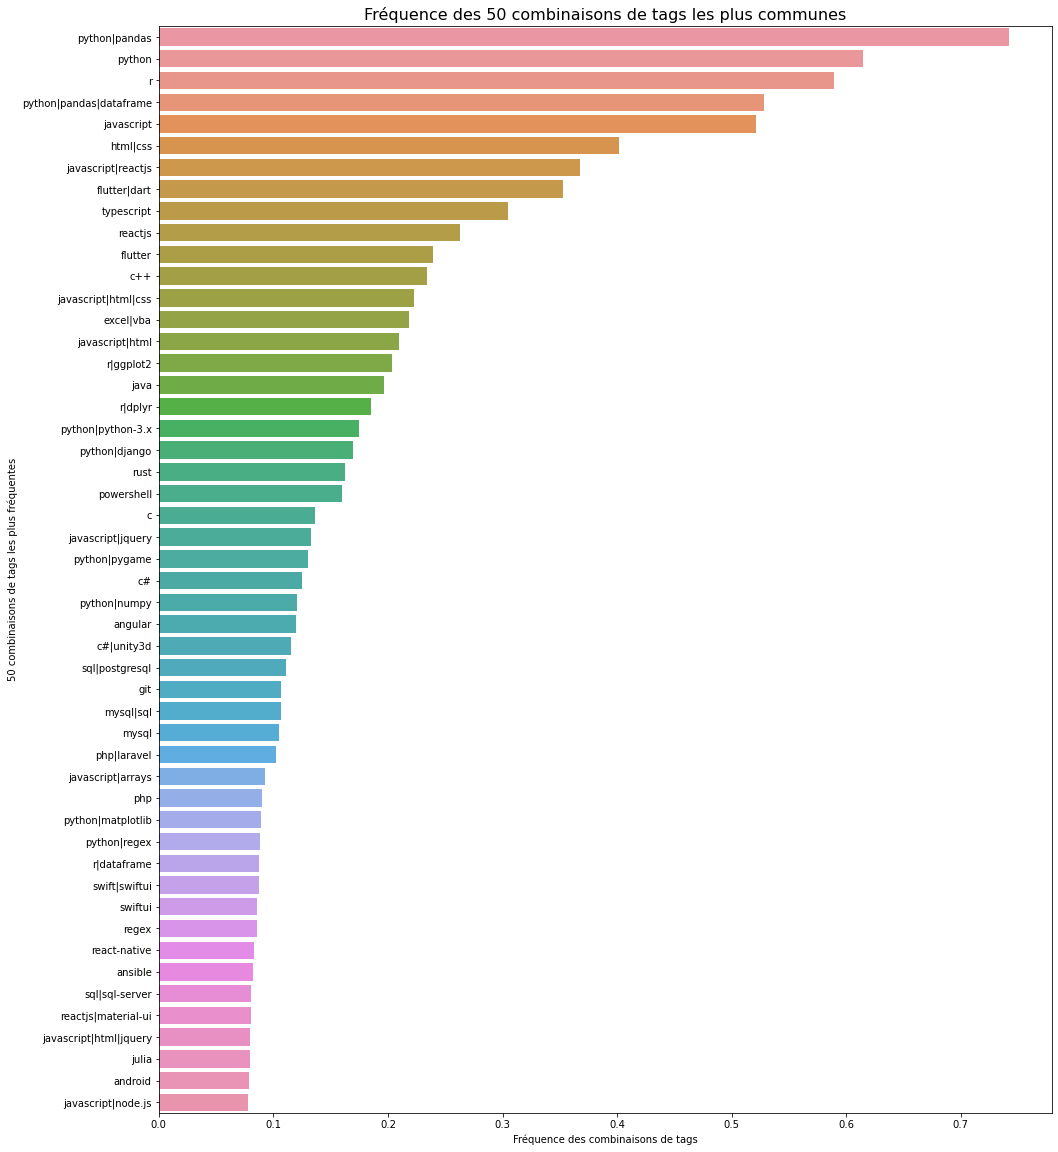

In [69]:
plt.figure(figsize=(16,20))
sns.barplot(x=100*df['tags'].value_counts(normalize=True)[:50].values, y=df['tags'].value_counts(normalize=True)[:50].index)
plt.xlabel('Fréquence des combinaisons de tags')
plt.ylabel('50 combinaisons de tags les plus fréquentes')
plt.title('Fréquence des 50 combinaisons de tags les plus communes', fontsize=16);

In [66]:
bag_of_tags = ' '.join(' '.join(df['tags'].to_list()).split('|'))

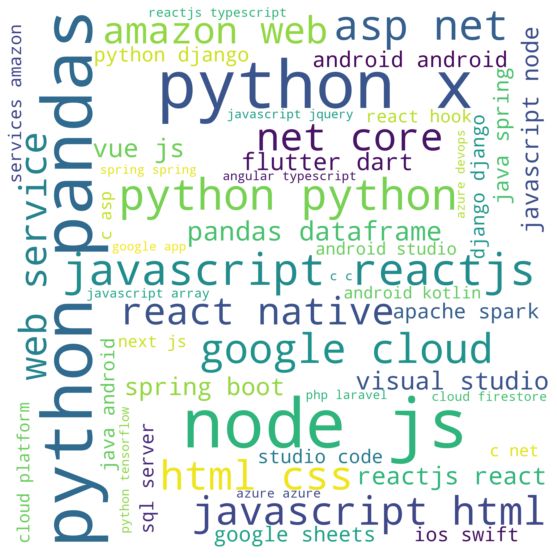

In [67]:
wordcloud = WordCloud(width=2048, height=2048, background_color="white", max_words=50).generate(bag_of_tags)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

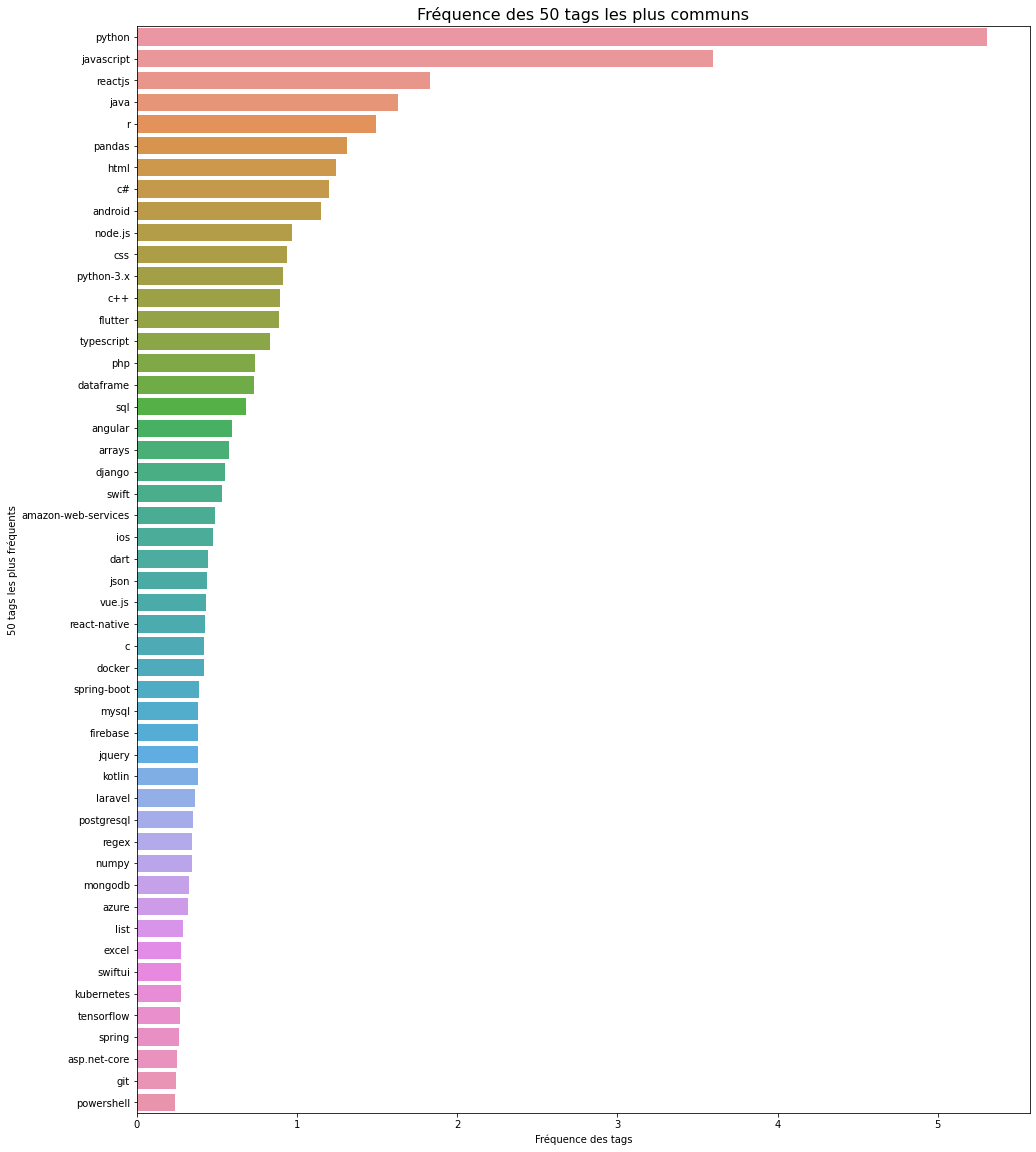

In [71]:
plt.figure(figsize=(16,20))
tags_serie = pd.Series(bag_of_tags.split())
sns.barplot(x=100*tags_serie.value_counts(normalize=True)[:50].values, y=tags_serie.value_counts(normalize=True)[:50].index)
plt.xlabel('Fréquence des tags')
plt.ylabel('50 tags les plus fréquents')
plt.title('Fréquence des 50 tags les plus communs', fontsize=16);

In [91]:
np.argwhere(np.cumsum(tags_serie.value_counts(normalize=True).values)>0.5)[0][0]

129

In [92]:
np.argwhere(np.cumsum(tags_serie.value_counts(normalize=True).values)>0.95)[0][0]

8722

In [77]:
tags_serie.nunique(), 130/tags_serie.nunique()

(39319, 0.003306289580101223)

In [104]:
dict_position_tags = dict(zip(tags_serie.value_counts(normalize=True).index, range(len(tags_serie))))

In [116]:
save_dict(dict_position_tags, 'dict_position_tags')

In [107]:
df['max_pos_tag'] = df['tags'].replace(dict_position_tags)

KeyboardInterrupt: 

In [ ]:
df['max_pos_tag'] = df['max_pos_tag'].str.split('|').apply(lambda x: np.max([int(y) for y in x]))

In [32]:
# Ajouter un graphique de bulles mouvantes  montrant l'évolution des 10 tags les plus communs dans le temps
# https://d3blocks.github.io/d3blocks/pages/html/MovingBubbles.html#movingbubbles

> Tous les tags sont des noms, nous rechercherons donc plus particulièrement des informations dans les noms contenus dans les titres et corps des posts !

## Creation_date

<AxesSubplot:xlabel='creation_date', ylabel='title'>

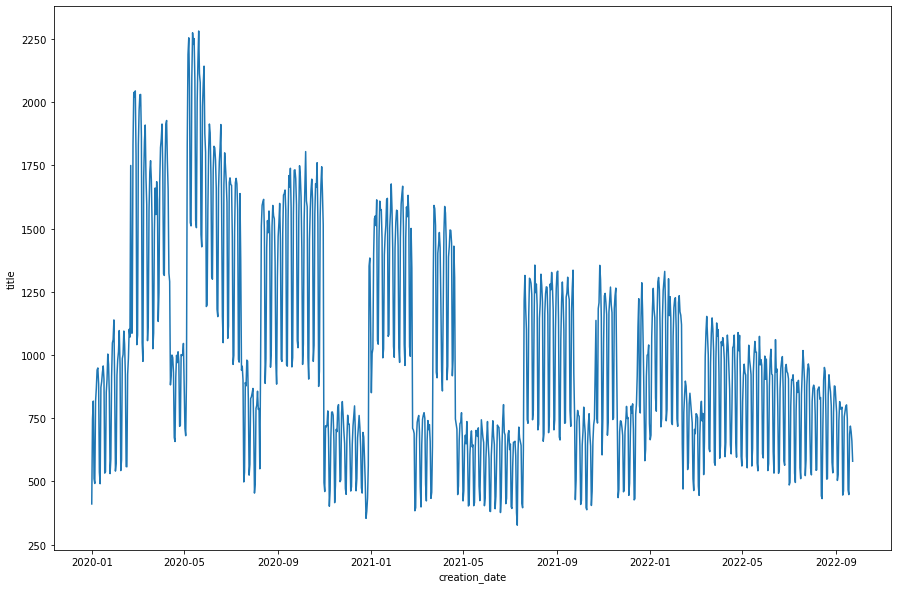

In [49]:
plt.rcParams["figure.figsize"]=[15,10]
sns.lineplot(x=df.groupby("creation_date").count().index[:-2], y=df.groupby("creation_date").count()['title'][:-2])

> On observe une tendance de fond baissière du nombre de posts publiés chaque jour sur la période **Janvier 2020** à **Septembre 2022**.

## Analyse bivariée

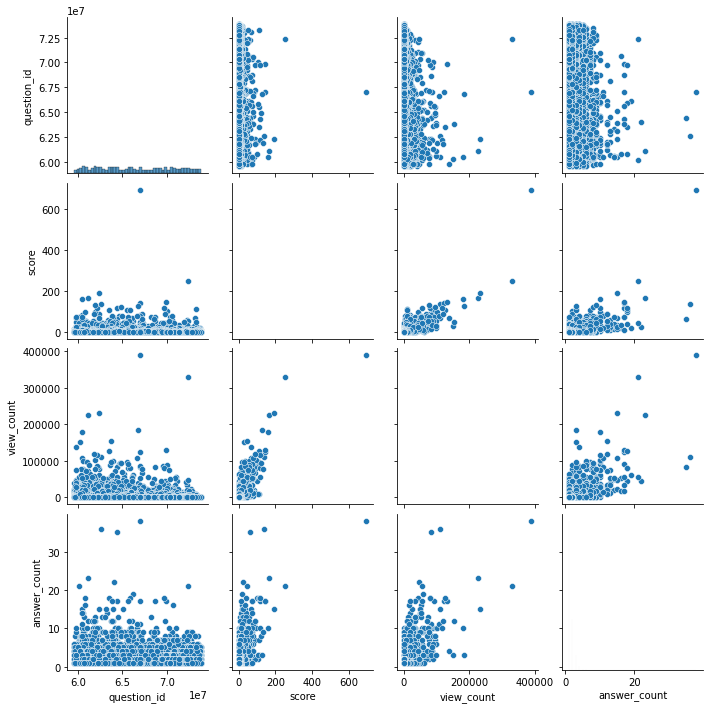

In [34]:
sns.pairplot(df.sample(100000))

<AxesSubplot:xlabel='creation_date', ylabel='score'>

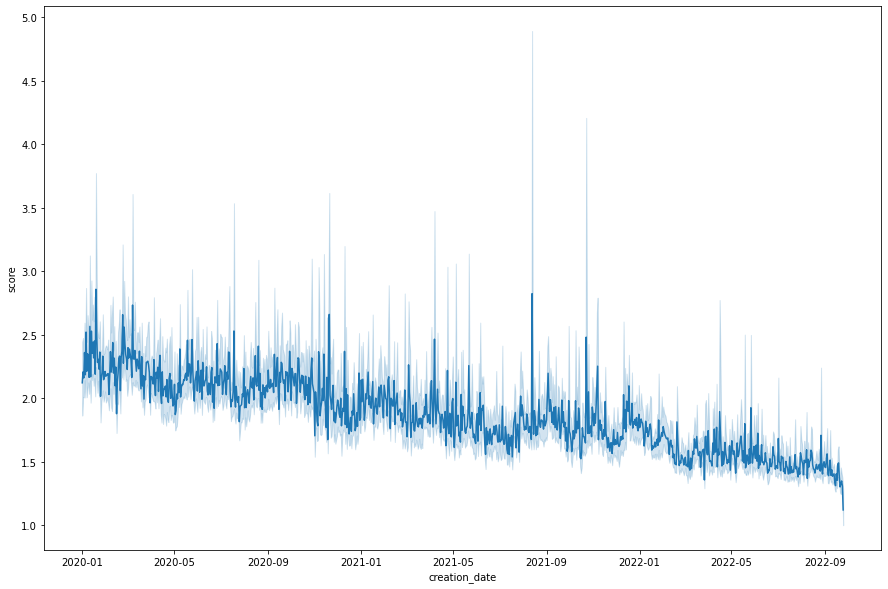

In [61]:
sns.lineplot(x=df["creation_date"], y=df["score"])

<AxesSubplot:xlabel='creation_date', ylabel='answer_count'>

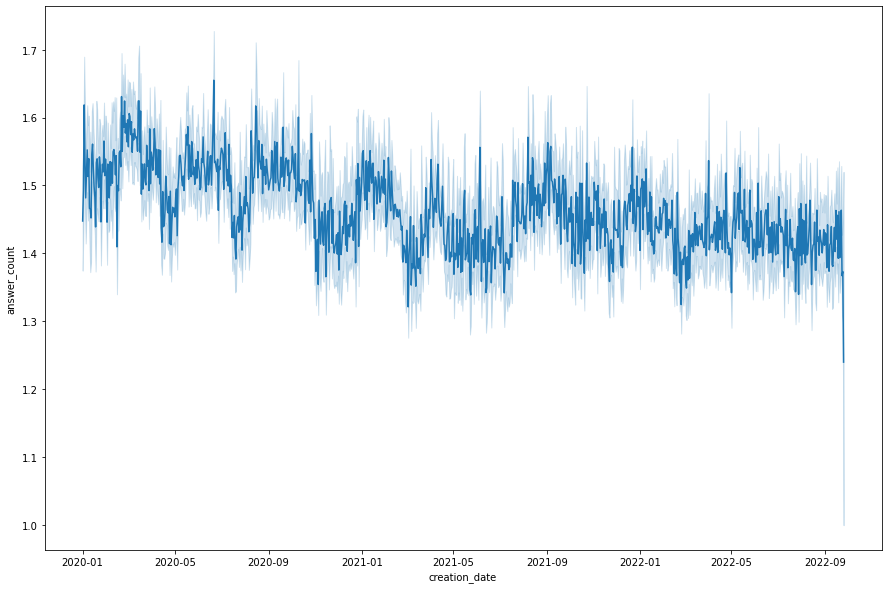

In [54]:
sns.lineplot(x=df["creation_date"], y=df["answer_count"])